In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
from scipy import linalg
from scipy import sparse
from scipy import ndimage
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-10-17 11:57:31.880718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Define functions to simulate dynamics

In [3]:
from scipy.integrate import solve_ivp

def fio_rect(x):
#     x[x<0] = 0
#     return x
    return np.fmax(x,0)

def dynamics_system(y,inp_ff,Wrec,\
                    gamma_rec,gamma_ff,N,tau):
#     argE = gamma_rec * np.dot(Wrec[:N],y) + gamma_ff * inp_ff[0]
#     argI = gamma_rec * np.dot(Wrec[N:],y) + gamma_ff * inp_ff[1]
#     return 1./tau*( -y + fio_rect(np.concatenate([argE,argI])))
    arg = gamma_rec * np.dot(Wrec,y) + gamma_ff * inp_ff.flatten()
    return 1./tau*( -y + fio_rect(arg))

def integrate(y0,inp,dt,Nt,Wrec,gamma_rec=1.02):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,Wrec,gamma_rec,1.0,N4*N4,1.0)
        dy = out
        y = y + dt*dy
    return np.array([y[:N4**2].reshape((N4,N4)),y[N4**2:].reshape((N4,N4))])
#     def ode_fun(t,y):
#         return dynamics_system(y,inp,Wrec,gamma_rec,1.0,N4*N4,1.0)
#     sol = solve_ivp(ode_fun,[0,dt*Nt],y0,method='RK23',first_step=dt)
#     return np.array([sol.y[:N4**2,-1].reshape((N4,N4)),sol.y[N4**2:,-1].reshape((N4,N4))])

# Construct Stevens et al recurrent weights

In [6]:
config_name = "ffrec_stevens"
Version = -1
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4,rA = uf.get_network_size(config_name,verbose=False)

start = time.process_time()

_,_,_,_,_,_,Whomo,Ahomo,_=uf.get_network_system_ffrec(Version,config_name)

print('Building connectivity matrices took',time.process_time() - start,'s')

print('Creating homogenous recurrent connectivity took',time.process_time() - start,'s')
np.save('stevens_homo_W4to4_N4={:d}'.format(N4),Whomo)

# Whomo = np.load('stevens_homo_W4to4_N4={:d}.npy'.format(N4))

Building connectivity matrices took 30.654478999999995 s
Creating homogenous recurrent connectivity took 30.655738 s


Text(0.5, 1.0, 'L4 I Cell (Pre)')

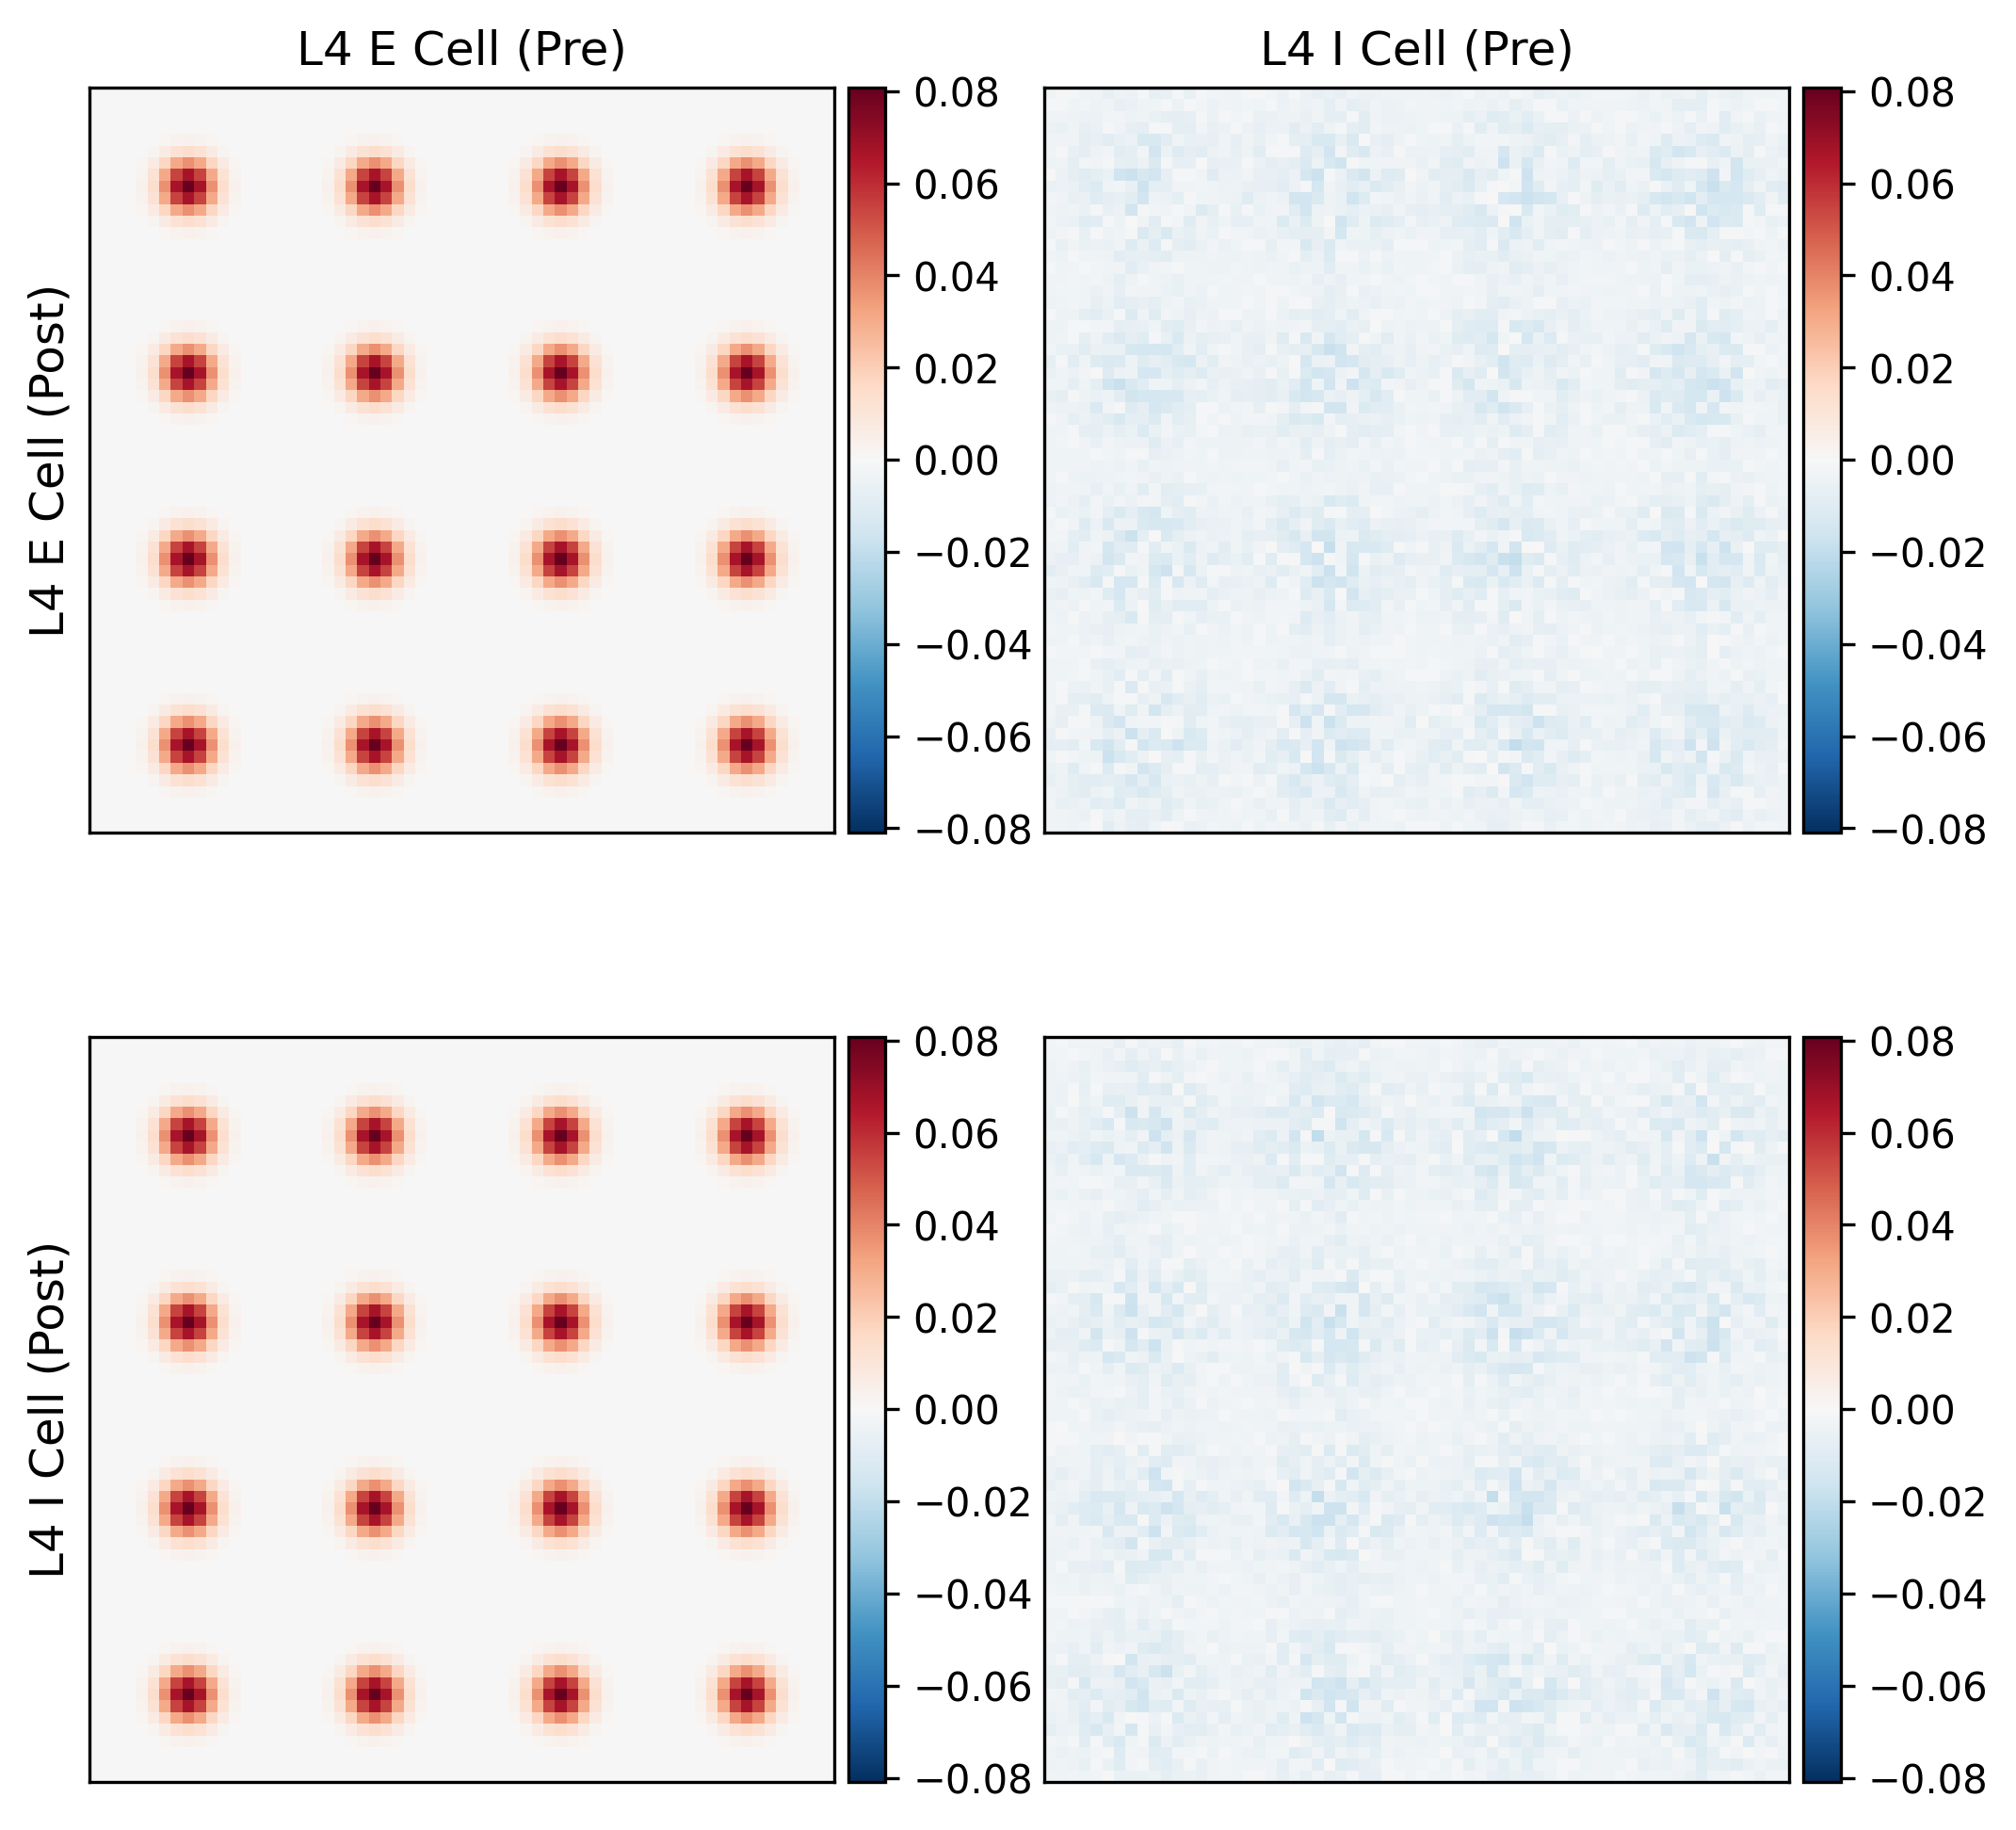

In [9]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N4,N4))
WEI = np.zeros((N4,N4))
WIE = np.zeros((N4,N4))
WII = np.zeros((N4,N4))

idxs = np.arange(N4//8,N4,N4//4)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4,N4))
        WEE += Whomo[:N4**2,:N4**2][:,rav_idx].reshape(N4,N4)
        WEI += Whomo[:N4**2,N4**2:][:,rav_idx].reshape(N4,N4)
        WIE += Whomo[N4**2:,:N4**2][:,rav_idx].reshape(N4,N4)
        WII += Whomo[N4**2:,N4**2:][:,rav_idx].reshape(N4,N4)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(Whomo)),vmax=np.max(np.abs(Whomo)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(Whomo)),vmax=np.max(np.abs(Whomo)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(Whomo)),vmax=np.max(np.abs(Whomo)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(Whomo)),vmax=np.max(np.abs(Whomo)),cmap='RdBu_r')

axs[0,0].set_ylabel('L4 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L4 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L4 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L4 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(Whomo,1,which='LR')
# print(eigval)

In [69]:
eigval,eigvec = sparse.linalg.eigs(Whomo,1,which='LR')
print(eigval)

[0.87332999-0.00153175j]


# Simulate dynamics with white-noise inputs

In [49]:
n_inp = 100
eta = 1e-2
inps = np.zeros((n_inp,2,N4,N4))

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,0,N4/4))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    for pop_idx in range(2):
        random_matrix = np.fft.fft2(rng.normal(size=(N4,N4)))
#         ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
        ring_ifft = np.real(np.fft.ifft2(random_matrix))
        inps[inp_idx,pop_idx,:,:] = 1 + eta*ring_ifft

In [50]:
# rates = np.zeros_like(inps)

# start = time.process_time()

# for inp_idx in range(n_inp):
#     rates[inp_idx] = integrate(np.ones(2*N4**2),inps[inp_idx].reshape((2,-1)),0.25,100,Whomo)
    
# print('Simulating rate dynamics took',time.process_time() - start,'s')
# np.save('stevens_homo_rates_N4={:d}'.format(N4),rates.flatten())

rates = np.load('stevens_homo_rates_N4={:d}.npy'.format(N4)).reshape((n_inp,2,N4,N4))

In [12]:
n_row = 5

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=((2*n_row+1)*10,n_row*10),dpi=150)

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     rates[idx,0],cmap='RdBu_r',
                     vmin=np.min(rates[:,0]),vmax=np.max(rates[:,0]))
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     rates[idx,1],cmap='RdBu_r',
                     vmin=np.min(rates[:,1]),vmax=np.max(rates[:,1]))

# Calculate the typical length scale

In [13]:
n_row = 5

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=((2*n_row+1)*10,n_row*10),dpi=150)

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2,
                     cmap='binary')
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2,
                     cmap='binary')

In [51]:
# fps_dat = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# fps_err = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
fps_dat = np.zeros(N4//2)
fps_err = np.zeros(N4//2)

grid = np.arange(-N4//2,N4//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.5)

for i in range(10):
    for j in range(10):
        idx = i*10+j
        
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2
        for bin_idx in range(N4//2):
            fps_dat[bin_idx] += np.mean(fp2[bin_idxs == bin_idx])
            fps_err[bin_idx] += np.var(fp2[bin_idxs == bin_idx])
            
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2
        for bin_idx in range(N4//2):
            fps_dat[bin_idx] += np.mean(fp2[bin_idxs == bin_idx])
            fps_err[bin_idx] += np.var(fp2[bin_idxs == bin_idx])

fps_dat /= 2*n_inp
fps_err /= 2*n_inp
fps_err = np.sqrt(fps_err / (2*n_inp))
# fps_dat /= n_inp
# fps_err /= n_inp
# fps_err = np.sqrt(fps_err / n_inp)

(0.0, 20.20240681086104)

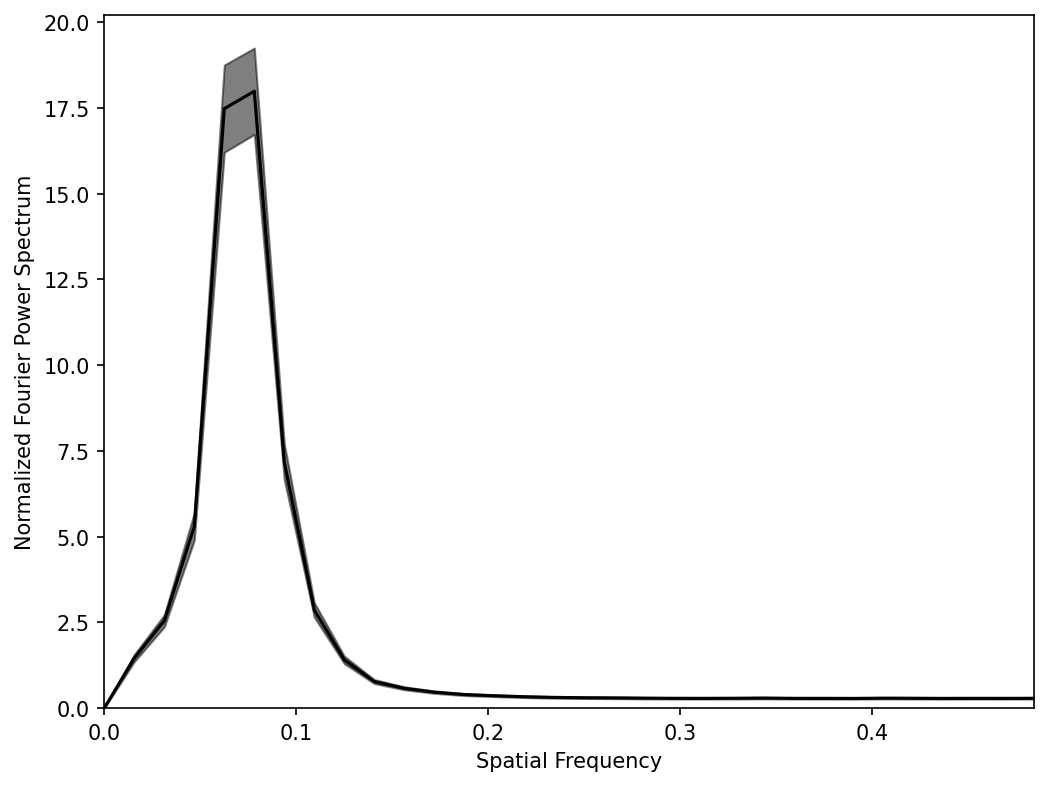

In [52]:
fig,axs = plt.subplots(1,1,figsize=(8,6),dpi=150)

# freqs = np.arange(int(np.ceil(N4//2*np.sqrt(2))))/N4
freqs = np.arange(N4//2)/N4

axs.plot(freqs,fps_dat/np.sum(fps_dat)*N4,'k')
axs.fill_between(freqs,(fps_dat+fps_err)/np.sum(fps_dat)*N4,
                 (fps_dat-fps_err)/np.sum(fps_dat)*N4,
                 color='k',alpha=0.5)

axs.set_xlabel('Spatial Frequency')
axs.set_ylabel('Normalized Fourier Power Spectrum')

axs.set_xlim(0,(N4//2-1)/N4)
axs.set_ylim(0,None)

In [53]:
Lam = 1/freqs[np.argmax(fps_dat)]
print('Λ =',Lam)

Λ = 12.8


# Construct heterogeneous Stevens et al recurrent weights

In [110]:
config_name = "ffrec_stevens_hetero"
Version = -1
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4,rA = uf.get_network_size(config_name,verbose=False)

# start = time.process_time()

# _,_,_,_,_,_,Whtro,Ahtro,_=uf.get_network_system_ffrec(Version,config_name)

# print('Building connectivity matrices took',time.process_time() - start,'s')

# print('Creating heterogeneous recurrent connectivity took',time.process_time() - start,'s')
# np.save('stevens_hetero_W4to4_N4={:d}'.format(N4),Whomo)

Whtro = np.load('stevens_hetero_W4to4_N4={:d}.npy'.format(N4))

Building connectivity matrices took 34.99406799999997 s
Creating heterogeneous recurrent connectivity took 34.99614699999984 s


Text(0.5, 1.0, 'L4 I Cell (Pre)')

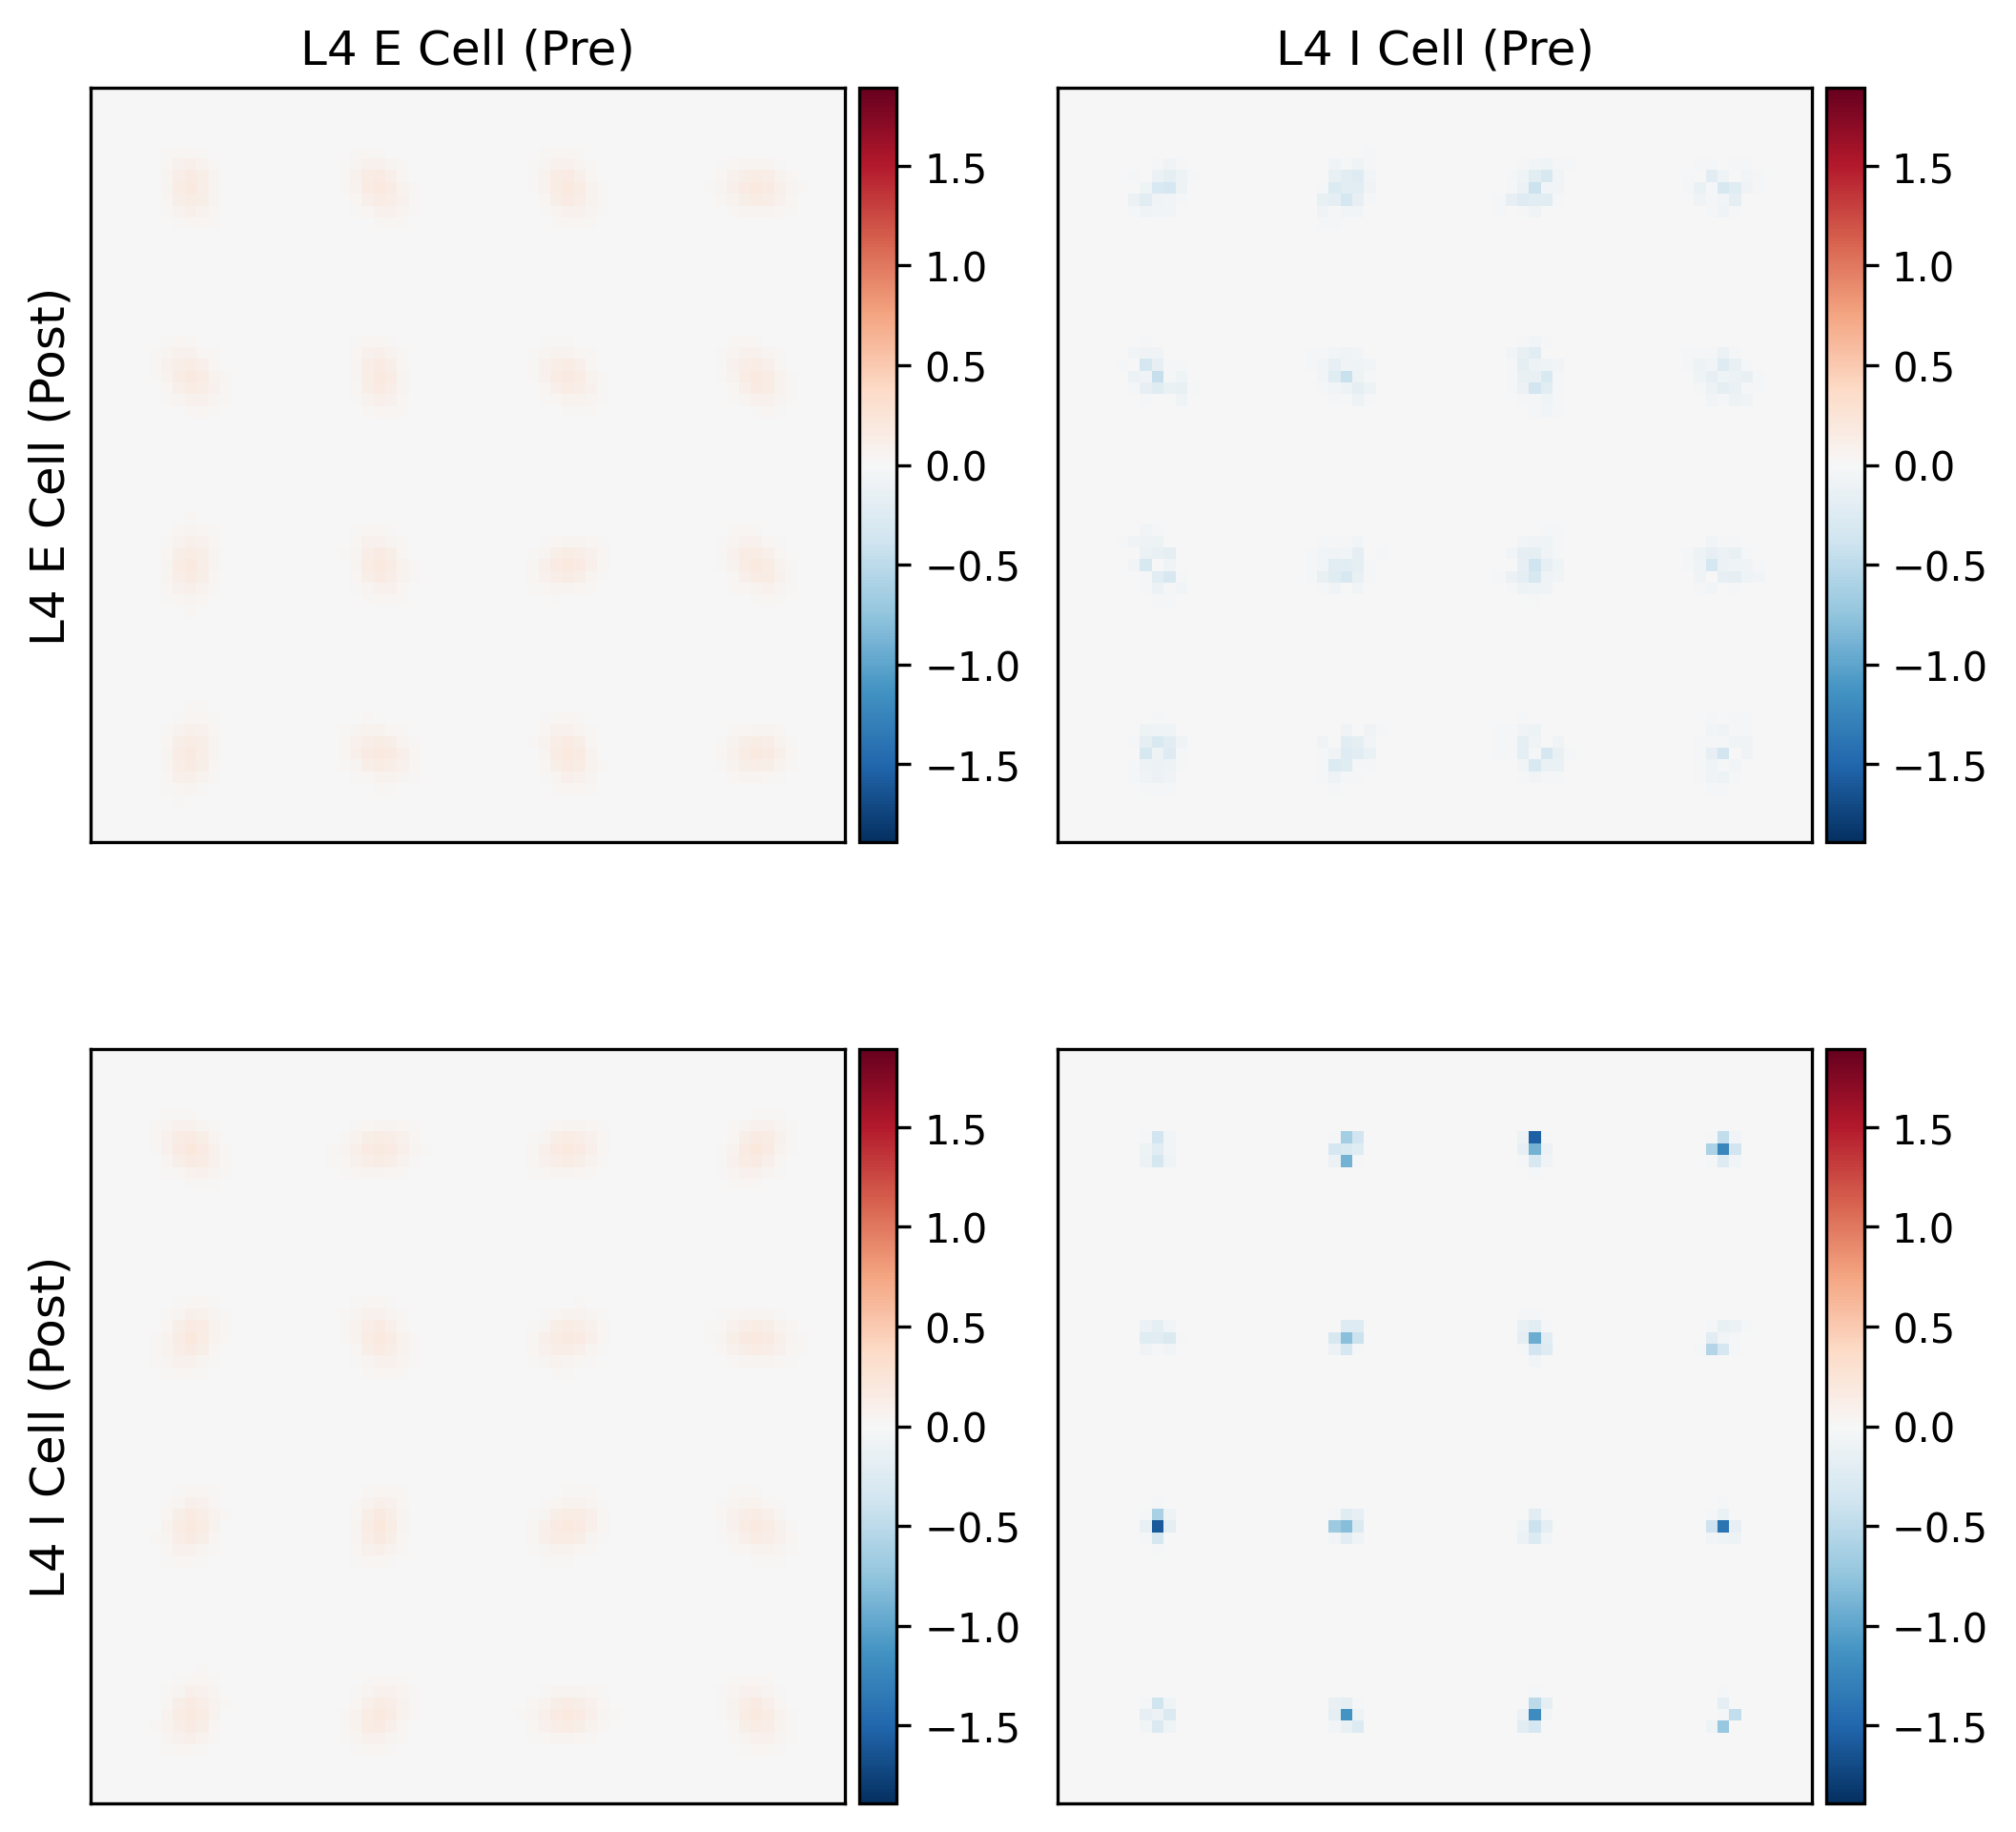

In [111]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N4,N4))
WEI = np.zeros((N4,N4))
WIE = np.zeros((N4,N4))
WII = np.zeros((N4,N4))

idxs = np.arange(N4//8,N4,N4//4)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4,N4))
        WEE += Whtro[:N4**2,:N4**2][:,rav_idx].reshape(N4,N4)
        WEI += Whtro[:N4**2,N4**2:][:,rav_idx].reshape(N4,N4)
        WIE += Whtro[N4**2:,:N4**2][:,rav_idx].reshape(N4,N4)
        WII += Whtro[N4**2:,N4**2:][:,rav_idx].reshape(N4,N4)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(Whtro)),vmax=np.max(np.abs(Whtro)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(Whtro)),vmax=np.max(np.abs(Whtro)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(Whtro)),vmax=np.max(np.abs(Whtro)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(Whtro)),vmax=np.max(np.abs(Whtro)),cmap='RdBu_r')

axs[0,0].set_ylabel('L4 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L4 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L4 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L4 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(Whtro,1,which='LR')
# print(eigval)

In [112]:
eigval,eigvec = sparse.linalg.eigs(Whtro,1,which='LR')
print(eigval)

[0.87283121+0.j]


# Simulate network with band-passed inputs around typical length scale

In [113]:
print('Λ/L =',Lam/N4)

Λ/L = 0.2


In [114]:
x,y = np.meshgrid(np.linspace(-N4//2,N4//2-1,N4),np.linspace(-N4//2,N4//2-1,N4))
sig1 = 1.8*1.1
sig2 = 3.6*1.1
kern1 = 1./(np.sqrt(np.pi*2)*sig1)**2*np.exp((-x**2-y**2)/2./sig1**2)
kern2 = 1./(np.sqrt(np.pi*2)*sig2)**2*np.exp((-x**2-y**2)/2./sig2**2)
diff_gauss = kern1-kern2

Text(0.5, 1.0, 'Noise Strength')

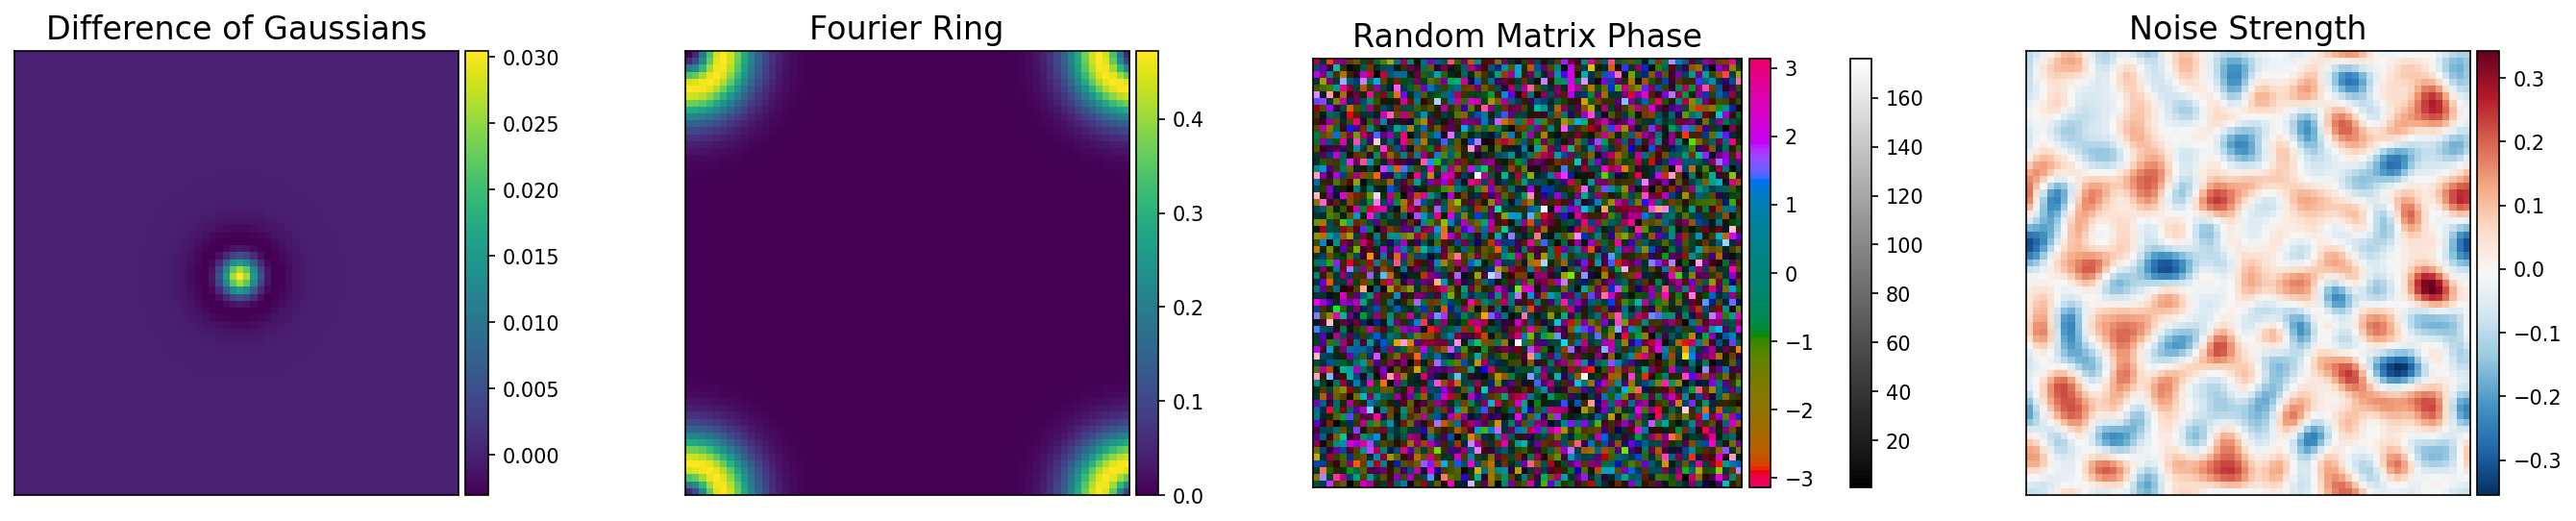

In [115]:
reload(gen_gaussian_random_field)

fig,axs = plt.subplots(1,4,figsize=(23,4),dpi=150)

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,1/(Lam/N4),N4/60))
ring_image = np.fft.fft2(np.fft.fftshift(diff_gauss))
random_matrix = np.fft.fft2(np.random.default_rng(0).normal(size=(N4,N4)))
# random_matrix = np.exp(-1j * np.angle(np.fft.fft2(np.random.randn(N4,N4))))
ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))

pf.imshowbar(fig,axs[0],diff_gauss,cmap='viridis')
pf.imshowbar(fig,axs[1],np.real(ring_image),cmap='viridis')
pf.domcolbar(fig,axs[2],random_matrix)
pf.imshowbar(fig,axs[3],ring_ifft,cmap='RdBu_r')

axs[0].set_title('Difference of Gaussians',fontsize=16)
axs[1].set_title('Fourier Ring',fontsize=16)
axs[2].set_title('Random Matrix Phase',fontsize=16)
axs[3].set_title('Noise Strength',fontsize=16)

In [116]:
n_inp = 25
eta = 1e-2
inps = np.zeros((n_inp,2,N4,N4))

ring_image = np.fft.fft2(np.fft.fftshift(diff_gauss))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    for pop_idx in range(2):
        random_matrix = np.fft.fft2(rng.normal(size=(N4,N4)))
        ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
        inps[inp_idx,pop_idx,:,:] = 1 + eta*ring_ifft

In [117]:
rates = np.zeros_like(inps)

start = time.process_time()

for inp_idx in range(n_inp):
    rates[inp_idx] = integrate(np.ones(2*N4**2),inps[inp_idx].reshape((2,-1)),0.25,100,Whtro)
    
print('Simulating rate dynamics took',time.process_time() - start,'s')
np.save('stevens_hetero_rates_N4={:d}'.format(N4),rates.flatten())

# rates = np.load('stevens_hetero_rates_N4={:d}.npy'.format(N4)).reshape((n_inp,2,N4,N4))

Simulating rate dynamics took 272.6978329999997 s


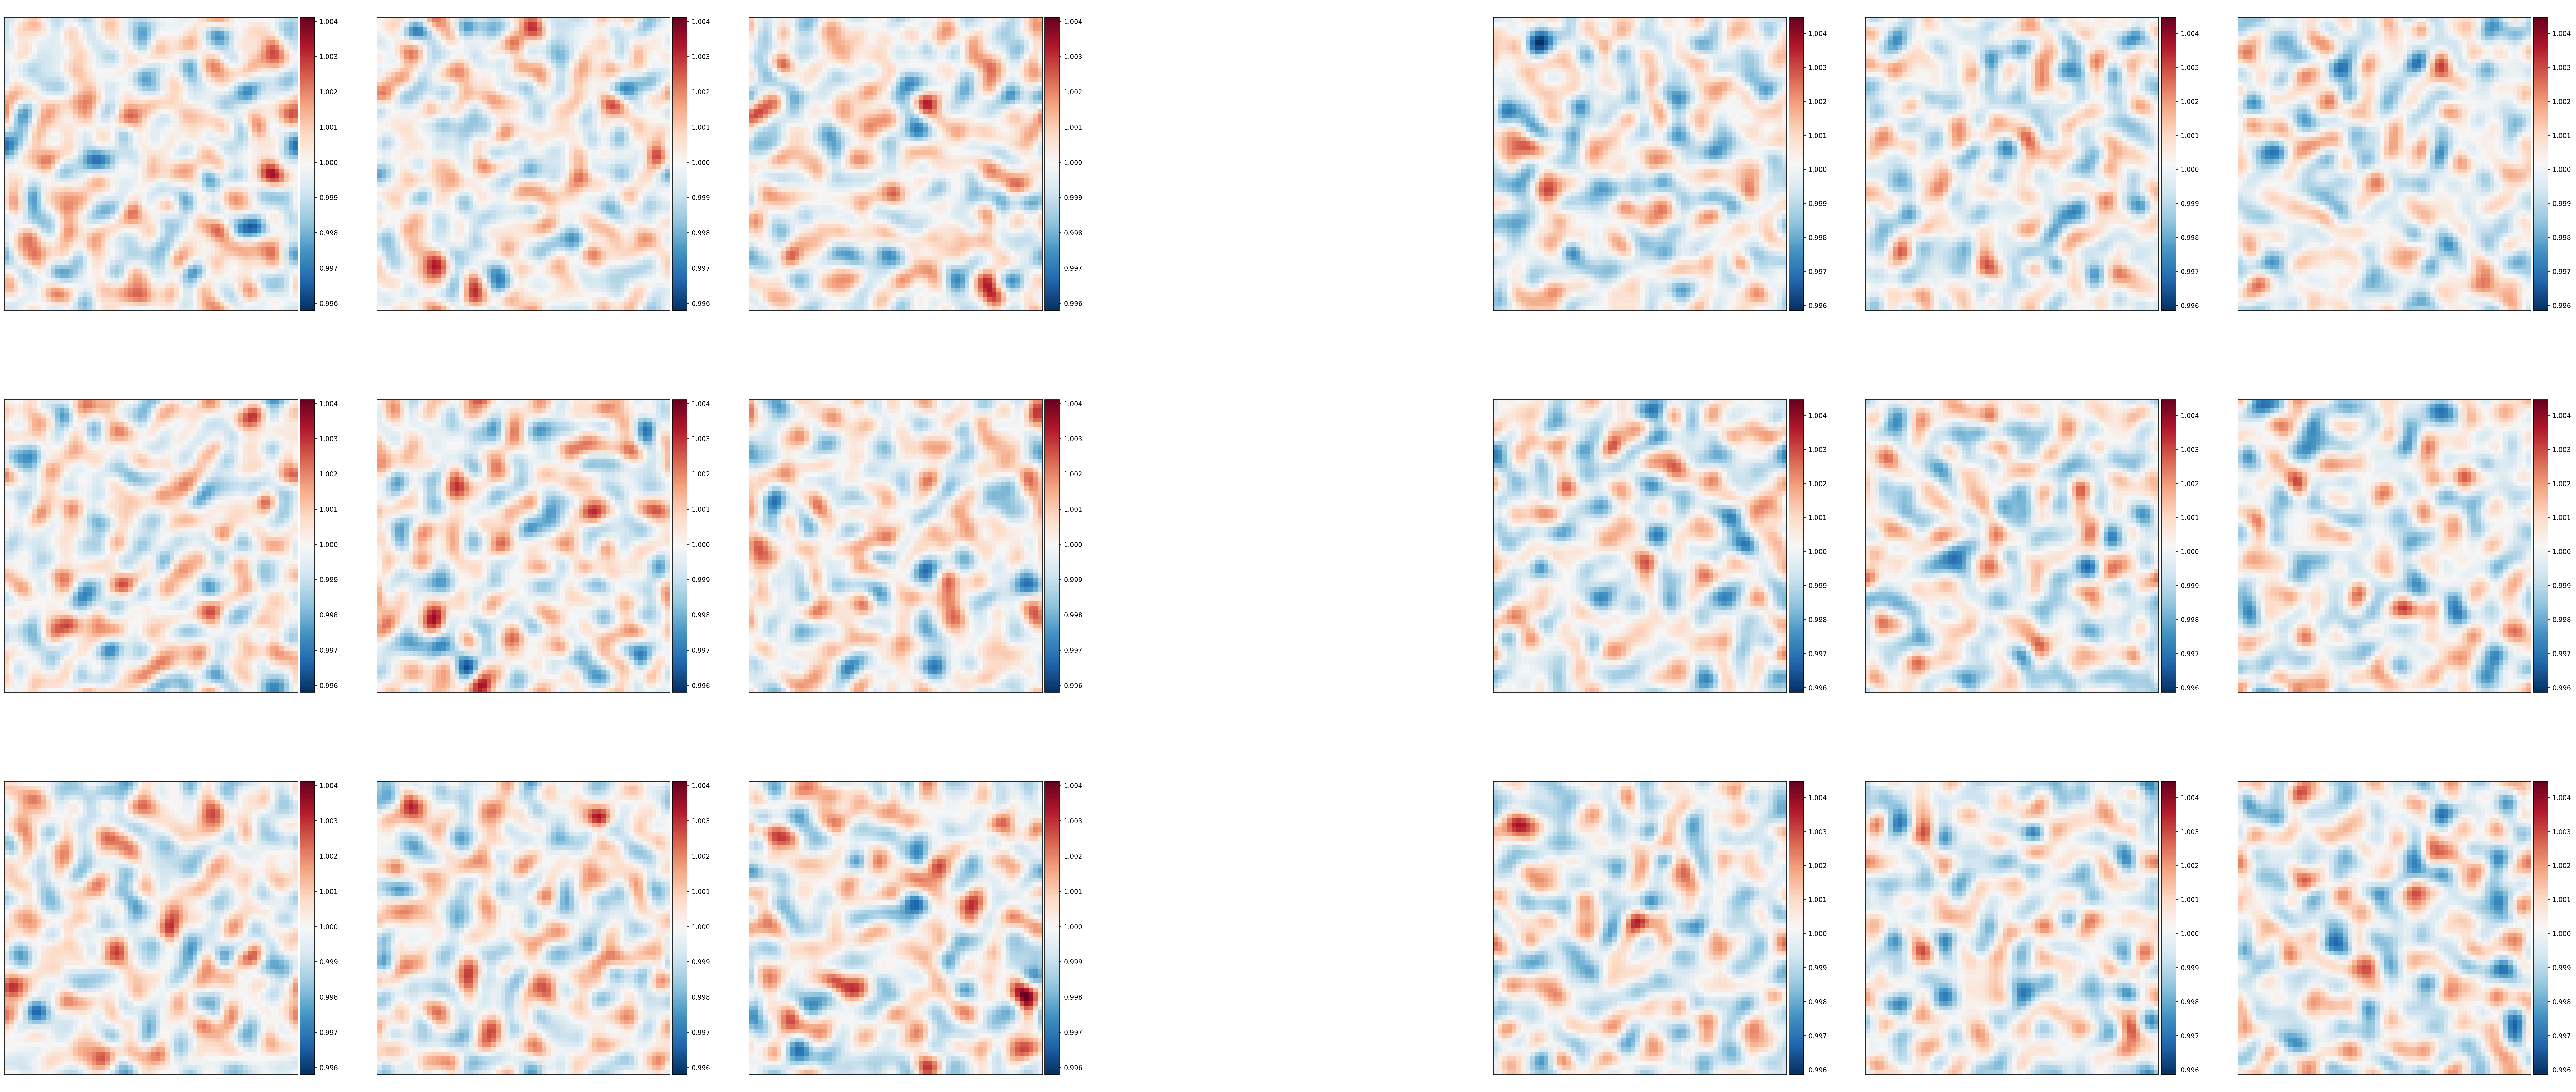

In [118]:
n_row = 3

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=((2*n_row+1)*10,n_row*10),dpi=150)

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     inps[idx,0],cmap='RdBu_r',
                     vmin=np.min(inps[:,0]),vmax=np.max(inps[:,0]))
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     inps[idx,1],cmap='RdBu_r',
                     vmin=np.min(inps[:,1]),vmax=np.max(inps[:,1]))

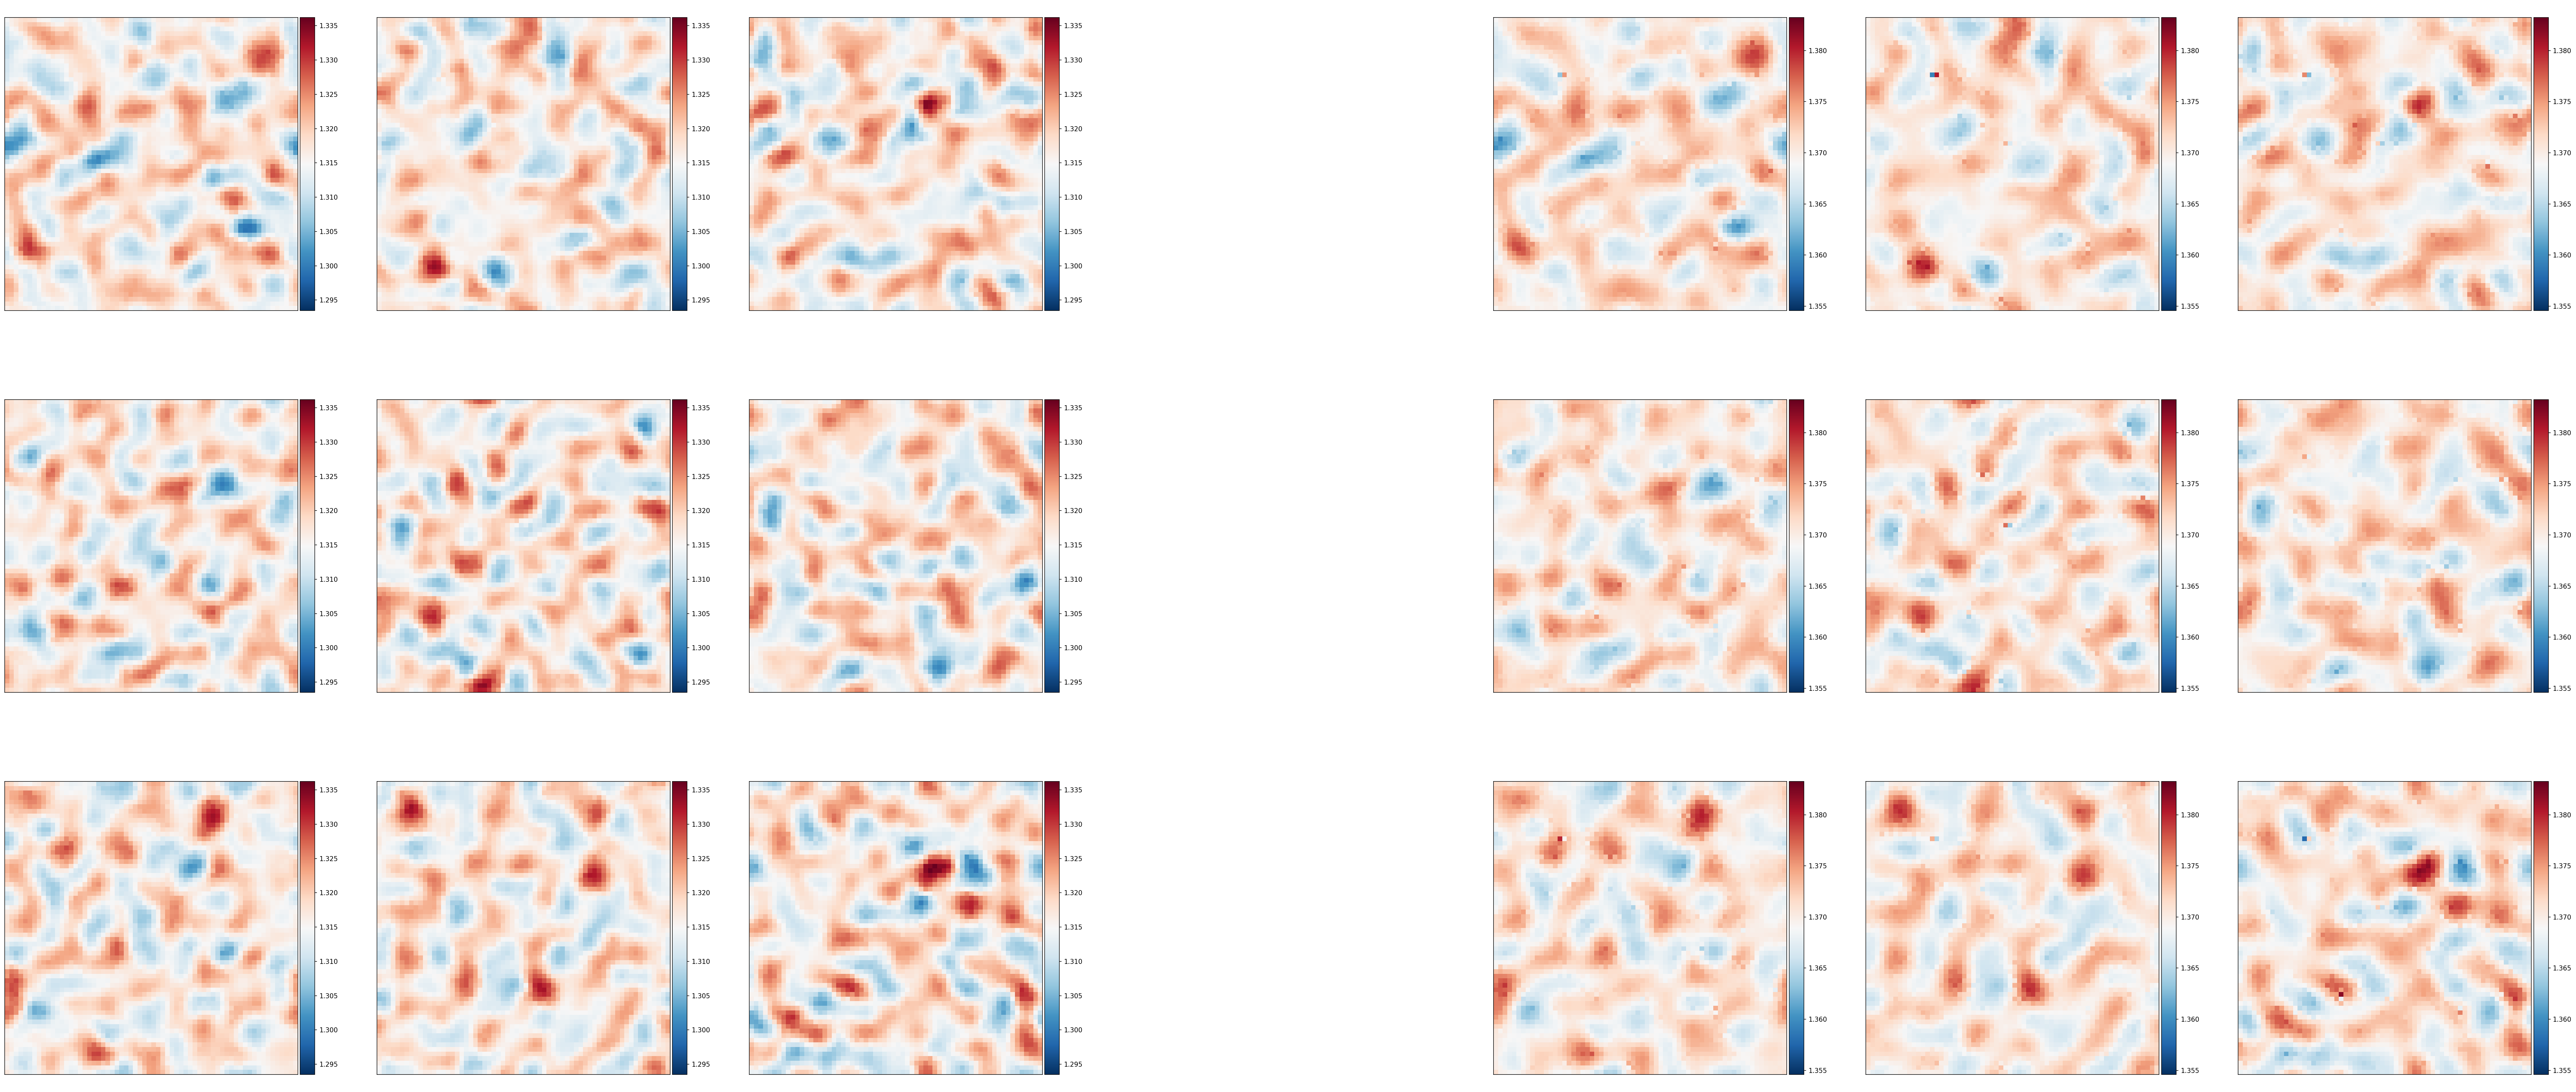

In [119]:
n_row = 3

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=((2*n_row+1)*10,n_row*10),dpi=150)

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     rates[idx,0],cmap='RdBu_r',
                     vmin=np.min(rates[:,0]),vmax=np.max(rates[:,0]))
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     rates[idx,1],cmap='RdBu_r',
                     vmin=np.min(rates[:,1]),vmax=np.max(rates[:,1]))

# Compare input power spectrum with rate power spectrum

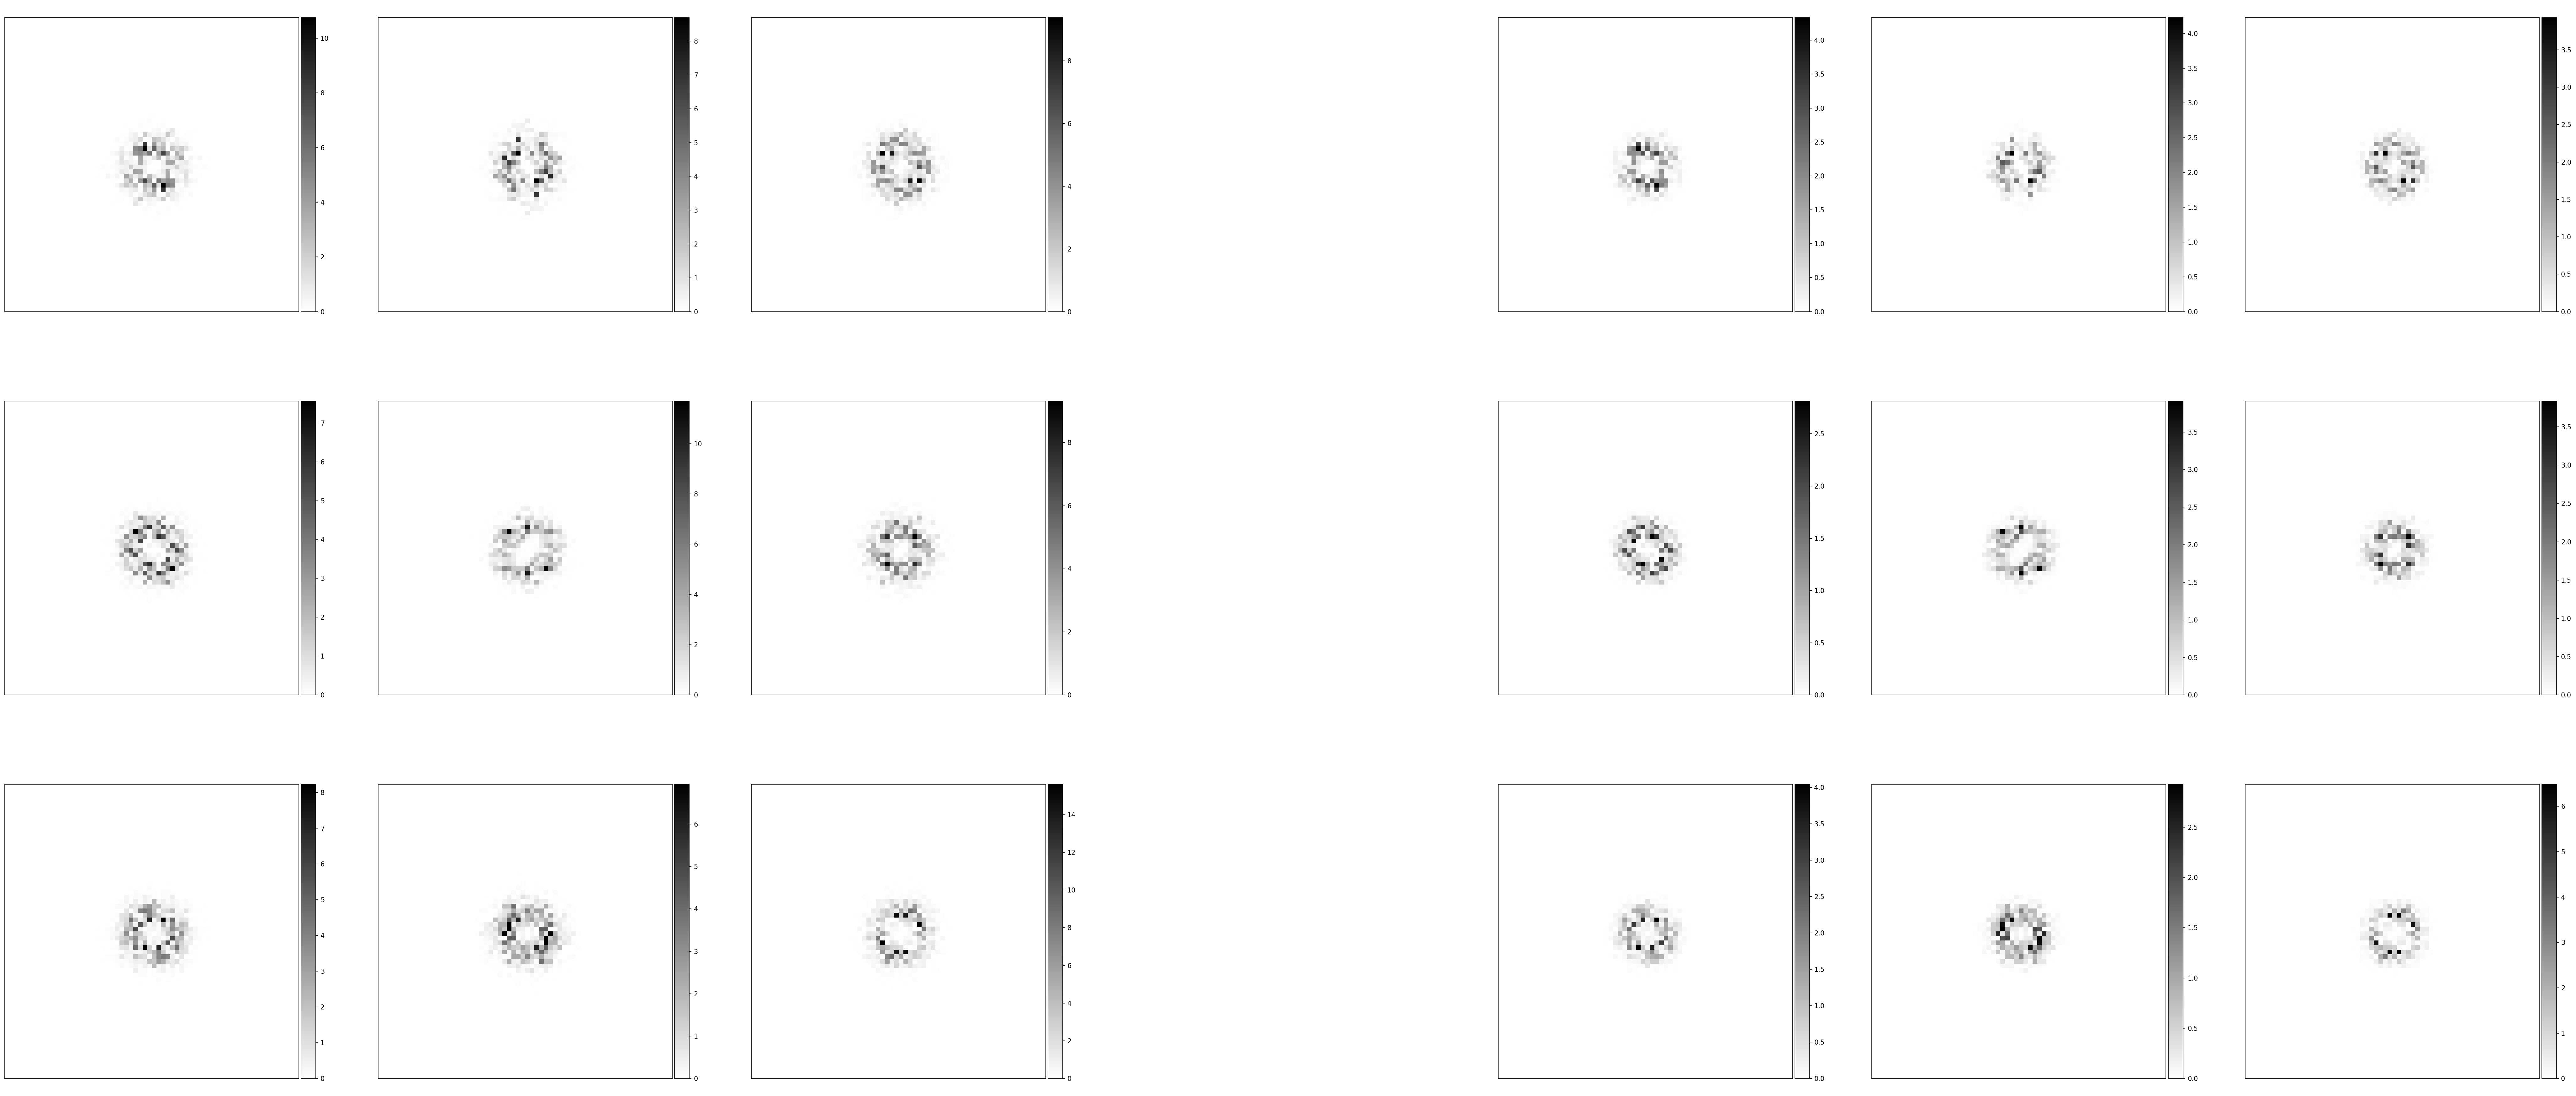

In [120]:
n_row = 3

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=((2*n_row+1)*10,n_row*10),dpi=150)

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2,
                     cmap='binary')
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2,
                     cmap='binary')

In [121]:
# inp_fps_dat = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# inp_fps_err = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# rate_fps_dat = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# rate_fps_err = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
inp_fps_dat = np.zeros(N4//2)
inp_fps_err = np.zeros(N4//2)
rate_fps_dat = np.zeros(N4//2)
rate_fps_err = np.zeros(N4//2)

grid = np.arange(-N4//2,N4//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.1)

for i in range(5):
    for j in range(5):
        idx = i*5+j
        
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(inps[idx,0]-np.nanmean(inps[idx,0]))))**2
        for bin_idx in range(N4//2):
            inp_fps_dat[bin_idx] += np.mean(fp2[bin_idxs == bin_idx])
            inp_fps_err[bin_idx] += np.var(fp2[bin_idxs == bin_idx])
            
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(inps[idx,1]-np.nanmean(inps[idx,1]))))**2
        for bin_idx in range(N4//2):
            inp_fps_dat[bin_idx] += np.mean(fp2[bin_idxs == bin_idx])
            inp_fps_err[bin_idx] += np.var(fp2[bin_idxs == bin_idx])
        
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2
        for bin_idx in range(N4//2):
            rate_fps_dat[bin_idx] += np.mean(fp2[bin_idxs == bin_idx])
            rate_fps_err[bin_idx] += np.var(fp2[bin_idxs == bin_idx])
            
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2
        for bin_idx in range(N4//2):
            rate_fps_dat[bin_idx] += np.mean(fp2[bin_idxs == bin_idx])
            rate_fps_err[bin_idx] += np.var(fp2[bin_idxs == bin_idx])

inp_fps_dat /= 2*n_inp
inp_fps_err /= 2*n_inp
inp_fps_err = np.sqrt(inp_fps_err / (2*n_inp))
rate_fps_dat /= 2*n_inp
rate_fps_err /= 2*n_inp
rate_fps_err = np.sqrt(rate_fps_err / (2*n_inp))

(0.0, 19.750285239009948)

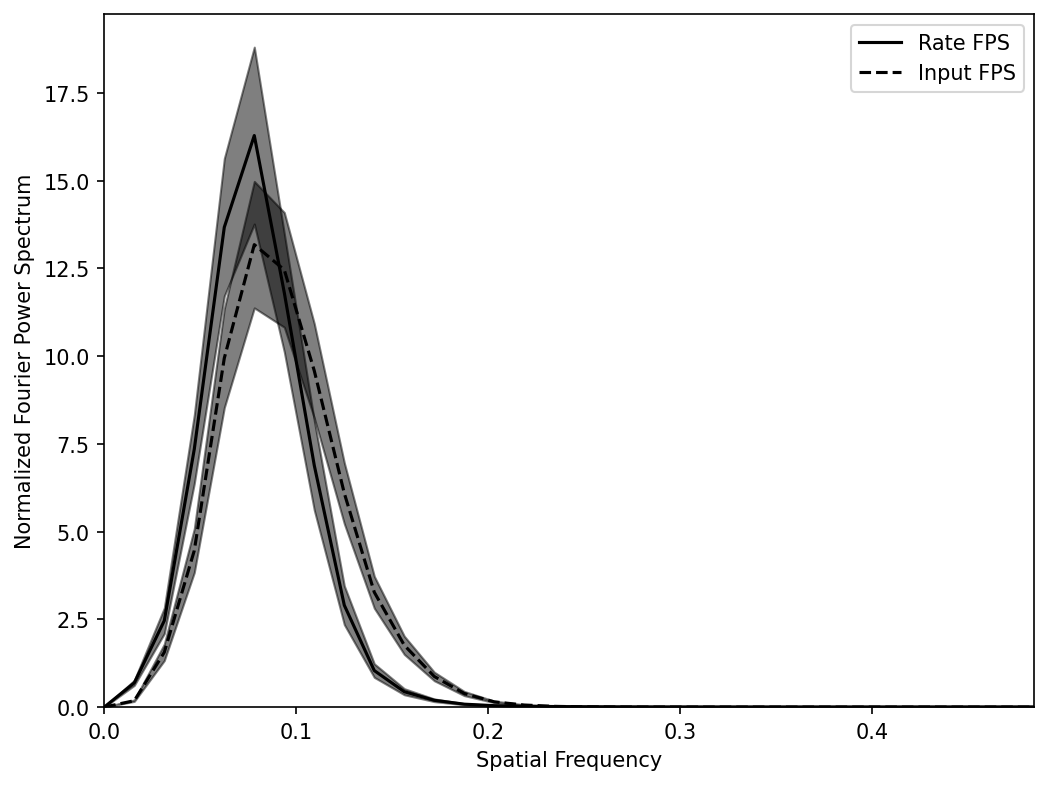

In [122]:
fig,axs = plt.subplots(1,1,figsize=(8,6),dpi=150)

freqs = np.arange(N4//2)/N4

axs.plot(freqs,rate_fps_dat/np.sum(rate_fps_dat)*N4,'k',label='Rate FPS')
axs.fill_between(freqs,(rate_fps_dat+rate_fps_err)/np.sum(rate_fps_dat)*N4,
                 (rate_fps_dat-rate_fps_err)/np.sum(rate_fps_dat)*N4,
                 color='k',alpha=0.5)
axs.plot(freqs,inp_fps_dat/np.sum(inp_fps_dat)*N4,'k--',label='Input FPS')
axs.fill_between(freqs,(inp_fps_dat+inp_fps_err)/np.sum(inp_fps_dat)*N4,
                 (inp_fps_dat-inp_fps_err)/np.sum(inp_fps_dat)*N4,
                 color='k',alpha=0.5)
axs.legend()

axs.set_xlabel('Spatial Frequency')
axs.set_ylabel('Normalized Fourier Power Spectrum')

axs.set_xlim(0,(N4//2-1)/N4)
axs.set_ylim(0,None)